# Bibliotheken

In [1]:
# Standardbibliotheken
import os
import pandas as pd
import numpy as np

# Visualisierungen
import matplotlib.pyplot as plt
import seaborn as sns

# librosa
import librosa
import librosa.display

# sklearn - Allgemein
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# sklearn – Vorverarbeitung & Dimensionsreduktion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, label_binarize
from sklearn.decomposition import PCA
import umap.umap_ as umap

# sklearn - Metriken
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc,
    roc_auc_score, classification_report, confusion_matrix, adjusted_rand_score,
    normalized_mutual_info_score, silhouette_score
)

# sklearn – ML-Algorithmen
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.inspection import permutation_importance

# weitere ML-Algorithmen
from xgboost import XGBClassifier

# weitere ML-Bibliotheken
import joblib

# Google Drive
from google.colab import drive

# Aus CSV laden

In [2]:
# Google Drive mounten
drive.mount('/content/drive')

# CSV laden
file_path = '/content/drive/MyDrive/DSI_Abschlussprojekt/emotion_dataset.csv'
df = pd.read_csv(file_path)

print(f"Datensatz wurde aus {file_path} geladen.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Datensatz wurde aus /content/drive/MyDrive/DSI_Abschlussprojekt/emotion_dataset.csv geladen.


# Datenübersicht


In [3]:
col_overview = (
    df.isna().sum()
      .reset_index()
      .rename(columns={"index": "column", 0: "n_missing"})
)
col_overview["dtype"] = df.dtypes.values
pd.set_option("display.max_rows", None)
print(col_overview)


                      column  n_missing    dtype
0                   modality          0    int64
1              vocal_channel          0    int64
2                    emotion          0    int64
3                  intensity          0    int64
4                  statement          0    int64
5                 repetition          0    int64
6                      actor          0    int64
7                mfcc_1_mean          0  float64
8                 mfcc_1_std          0  float64
9                mfcc_2_mean          0  float64
10                mfcc_2_std          0  float64
11               mfcc_3_mean          0  float64
12                mfcc_3_std          0  float64
13               mfcc_4_mean          0  float64
14                mfcc_4_std          0  float64
15               mfcc_5_mean          0  float64
16                mfcc_5_std          0  float64
17               mfcc_6_mean          0  float64
18                mfcc_6_std          0  float64
19               mfc

# ML-Vorbereitung

In [4]:
# Metadaten und Zielvariablen entfernen um Data Leakage zu vermeiden
drop_cols = [
    "modality", "vocal_channel", "emotion", "intensity",
    "statement", "repetition", "actor",
    "file_path", "emotion_label", "intensity_label",
    "statement_label", "gender"
]

# Numerische Features und Zielvariable definieren
X = df.drop(columns=drop_cols, errors="ignore").select_dtypes(include=[np.number])
y = df["emotion_label"]

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Logistische Regression

Logistische Regression – Ergebnisse
Cross-Validation (5-fold) Macro-F1: 0.62 ± 0.02
------------------------------------------------------------
Test-Set Performance:

             precision recall f1-score  support
angry             0.67   0.63     0.65       38
calm              0.63   0.76     0.69       38
disgust           0.43   0.53     0.48       38
fearful           0.75   0.69     0.72       39
happy             0.60   0.54     0.57       39
neutral           0.21   0.32     0.26       19
sad               0.55   0.45     0.49       38
surprised         0.77   0.59     0.67       39
accuracy          0.58   0.58     0.58        0
macro avg         0.58   0.56     0.56      288
weighted avg      0.60   0.58     0.59      288
------------------------------------------------------------
Accuracy : 0.58
Macro F1 : 0.56



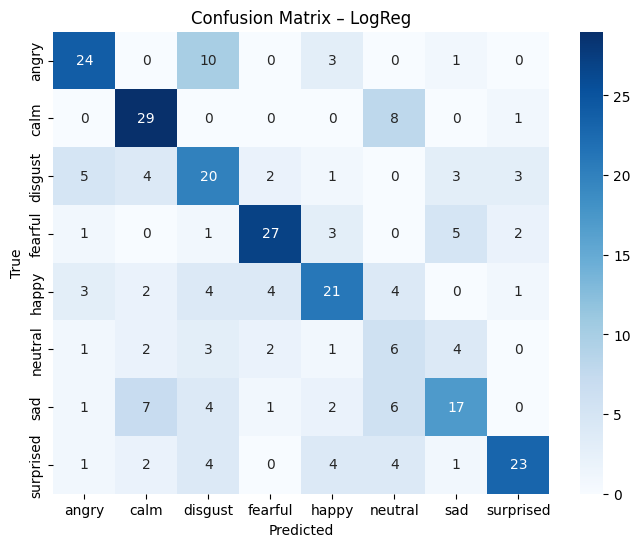


Modell gespeichert unter: logreg_model.joblib


In [5]:
# Pipeline
logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

# K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(logreg, X, y, cv=cv, scoring='f1_macro')

print('Logistische Regression – Ergebnisse')
print('='*60)
print(f"Cross-Validation (5-fold) Macro-F1: {scores.mean():.2f} ± {scores.std():.2f}")
print('-'*60)

# Trainieren
logreg.fit(X_train, y_train)

# Evaluieren
y_pred = logreg.predict(X_test)

# Report formatieren
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).T
report_df['precision'] = report_df['precision'].map('{:.2f}'.format)
report_df['recall']    = report_df['recall'].map('{:.2f}'.format)
report_df['f1-score']  = report_df['f1-score'].map('{:.2f}'.format)
report_df['support']   = report_df['support'].astype(int)

print('Test-Set Performance:\n')
print(report_df.to_string())
print('-'*60)
print(f"Accuracy : {accuracy_score(y_test, y_pred):.2f}")
print(f"Macro F1 : {f1_score(y_test, y_pred, average='macro'):.2f}\n")

# Konfusionmatrix als Heatmap
labels = sorted(y_test.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix – LogReg')
plt.show()

# Speichern
joblib.dump(logreg, 'logreg_model.joblib')
print(f"\nModell gespeichert unter: logreg_model.joblib")

# Support Vector Machines (SVM)

Support Vector Machine – Ergebnisse
Cross-Validation (5-fold) Macro-F1: 0.65 ± 0.02
------------------------------------------------------------
Test-Set Performance:

             precision recall f1-score  support
angry             0.77   0.61     0.68       38
calm              0.50   0.95     0.65       38
disgust           0.58   0.76     0.66       38
fearful           0.77   0.59     0.67       39
happy             0.68   0.54     0.60       39
neutral           0.60   0.32     0.41       19
sad               0.47   0.42     0.44       38
surprised         0.90   0.72     0.80       39
accuracy          0.63   0.63     0.63        0
macro avg         0.66   0.61     0.61      288
weighted avg      0.66   0.63     0.63      288
------------------------------------------------------------
Accuracy : 0.63
Macro F1 : 0.61



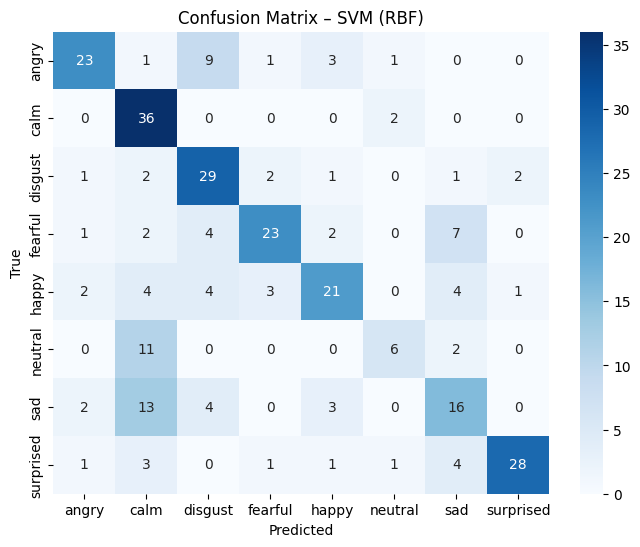


Modell gespeichert unter: svm_model.joblib


In [6]:
# Pipeline
svm = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='rbf', probability=True, random_state=42))  # RBF-Kernel für Audio-Daten besser
])

# K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(svm, X, y, cv=cv, scoring='f1_macro', n_jobs=-1)

print('Support Vector Machine – Ergebnisse')
print('='*60)
print(f"Cross-Validation (5-fold) Macro-F1: {scores.mean():.2f} ± {scores.std():.2f}")
print('-'*60)

# Trainieren
svm.fit(X_train, y_train)

# Evaluieren
y_pred = svm.predict(X_test)

# Report formatieren
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).T
report_df['precision'] = report_df['precision'].map('{:.2f}'.format)
report_df['recall']    = report_df['recall'].map('{:.2f}'.format)
report_df['f1-score']  = report_df['f1-score'].map('{:.2f}'.format)
report_df['support']   = report_df['support'].astype(int)

print('Test-Set Performance:\n')
print(report_df.to_string())
print('-'*60)
print(f"Accuracy : {accuracy_score(y_test, y_pred):.2f}")
print(f"Macro F1 : {f1_score(y_test, y_pred, average="macro"):.2f}\n")

# Konfusionsmatrix als Heatmap
labels = sorted(y_test.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix – SVM (RBF)')
plt.show()

# Speichern
joblib.dump(svm, 'svm_model.joblib')
print(f"\nModell gespeichert unter: svm_model.joblib")


# Random Forest

Random Forest – Ergebnisse
Cross-Validation (5-fold) Macro-F1: 0.64 ± 0.03
------------------------------------------------------------
Test-Set Performance:

             precision recall f1-score  support
angry             0.79   0.71     0.75       38
calm              0.53   0.92     0.67       38
disgust           0.50   0.63     0.56       38
fearful           0.71   0.51     0.60       39
happy             0.67   0.56     0.61       39
neutral           0.67   0.32     0.43       19
sad               0.50   0.47     0.49       38
surprised         0.76   0.67     0.71       39
accuracy          0.62   0.62     0.62        0
macro avg         0.64   0.60     0.60      288
weighted avg      0.64   0.62     0.61      288
------------------------------------------------------------
Accuracy : 0.62
Macro F1 : 0.60



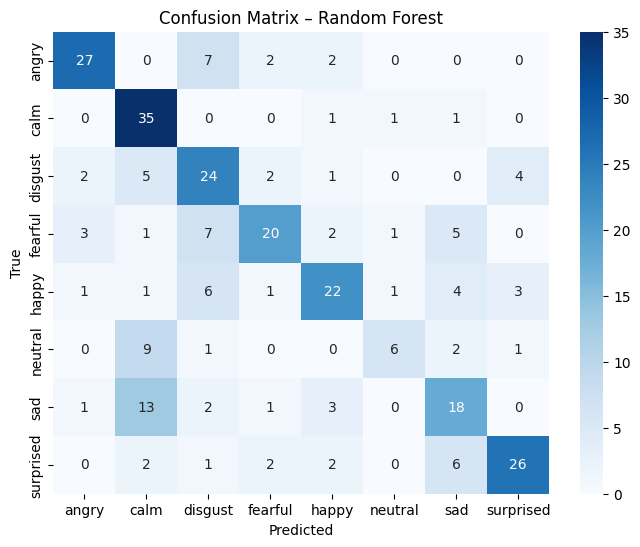


Modell gespeichert unter: rf_model.joblib


In [7]:
# Pipeline
rf = Pipeline([
    ('scaler', 'passthrough'),  # Random Forest braucht keine Skalierung
    ('clf', RandomForestClassifier(
        n_estimators=400,
        max_depth=20,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        class_weight=None,
        random_state=42,
        n_jobs=-1
    ))
])

# K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf, X, y, cv=cv, scoring='f1_macro', n_jobs=-1)

print('Random Forest – Ergebnisse')
print('='*60)
print(f"Cross-Validation (5-fold) Macro-F1: {scores.mean():.2f} ± {scores.std():.2f}")
print('-'*60)

# Trainieren
rf.fit(X_train, y_train)

# Evaluieren
y_pred = rf.predict(X_test)

# Report formatieren
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).T
report_df['precision'] = report_df['precision'].map('{:.2f}'.format)
report_df['recall']    = report_df['recall'].map('{:.2f}'.format)
report_df['f1-score']  = report_df['f1-score'].map('{:.2f}'.format)
report_df['support']   = report_df['support'].astype(int)

print('Test-Set Performance:\n')
print(report_df.to_string())
print('-'*60)
print(f"Accuracy : {accuracy_score(y_test, y_pred):.2f}")
print(f"Macro F1 : {f1_score(y_test, y_pred, average='macro'):.2f}\n")

# Konfusionsmatrix als Heatmap
labels = sorted(y_test.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix – Random Forest')
plt.show()

# Speichern
joblib.dump(rf, 'rf_model.joblib')
print(f"\nModell gespeichert unter: rf_model.joblib")


# Gradient Boosting (XGBoost)


XGBoost – Ergebnisse
Cross-Validation (5-fold) Macro-F1: 0.71 ± 0.02
------------------------------------------------------------
Test-Set Performance:

             precision recall f1-score  support
angry             0.81   0.79     0.80       38
calm              0.64   0.95     0.77       38
disgust           0.63   0.71     0.67       38
fearful           0.71   0.56     0.63       39
happy             0.76   0.64     0.69       39
neutral           0.59   0.53     0.56       19
sad               0.58   0.58     0.58       38
surprised         0.82   0.69     0.75       39
accuracy          0.69   0.69     0.69        0
macro avg         0.69   0.68     0.68      288
weighted avg      0.70   0.69     0.69      288
------------------------------------------------------------
Accuracy : 0.69
Macro F1 : 0.68



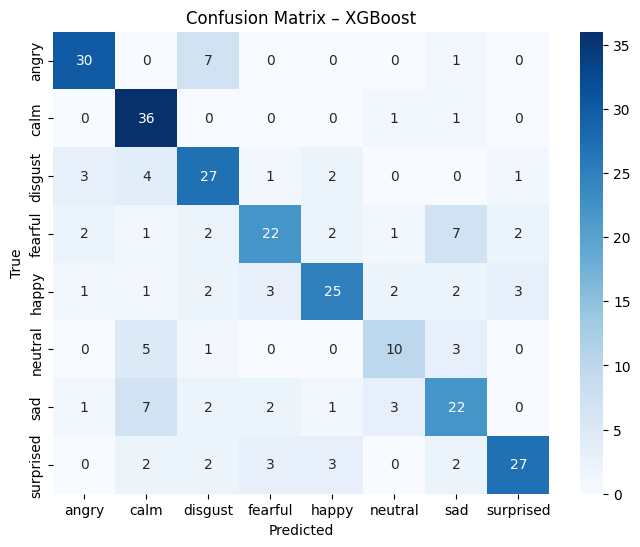


Modell gespeichert unter: xgb_model.joblib


In [8]:
# Label-Encoding für XGBoost
label_encoder = LabelEncoder()

# Für Cross-Validation encoden
y_encoded = label_encoder.fit_transform(y)

# Train- und Test-Labels encoden
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded  = label_encoder.transform(y_test)

# Pipeline
xgb = Pipeline([
    ('scaler', 'passthrough'),  # XGBoost braucht keine Skalierung
    ('clf', XGBClassifier(
        n_estimators=1400,
        max_depth=5,
        learning_rate=0.07,
        subsample=0.8,
        colsample_bytree=0.6,
        random_state=42,
        n_jobs=-1,
        objective='multi:softprob',
        eval_metric='mlogloss',
    ))
])

# K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xgb, X, y_encoded, cv=cv, scoring='f1_macro', n_jobs=-1)

print('XGBoost – Ergebnisse')
print('='*60)
print(f"Cross-Validation (5-fold) Macro-F1: {scores.mean():.2f} ± {scores.std():.2f}")
print('-'*60)

# Trainieren
xgb.fit(X_train, y_train_encoded)

# Evaluieren
y_pred_encoded = xgb.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Report formatieren
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).T
report_df['precision'] = report_df['precision'].map('{:.2f}'.format)
report_df['recall']    = report_df['recall'].map('{:.2f}'.format)
report_df['f1-score']  = report_df['f1-score'].map('{:.2f}'.format)
report_df['support']   = report_df['support'].astype(int)

print('Test-Set Performance:\n')
print(report_df.to_string())
print('-'*60)
print(f"Accuracy : {accuracy_score(y_test, y_pred):.2f}")
print(f"Macro F1 : {f1_score(y_test, y_pred, average='macro'):.2f}\n")

# Konfusionsmatrix als Heatmap
labels = list(label_encoder.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix – XGBoost')
plt.show()

# Speichern
joblib.dump(xgb, 'xgb_model.joblib')
print(f"\nModell gespeichert unter: xgb_model.joblib")

# Support Vector Machines (SVM) + PCA

Support Vector Machine + PCA – Ergebnisse
Cross-Validation (5-fold) Macro-F1: 0.79 ± 0.02
------------------------------------------------------------
Test-Set Performance:

             precision recall f1-score  support
angry             0.77   0.79     0.78       38
calm              0.82   0.97     0.89       38
disgust           0.76   0.82     0.78       38
fearful           0.79   0.67     0.72       39
happy             0.73   0.69     0.71       39
neutral           0.68   0.79     0.73       19
sad               0.68   0.68     0.68       38
surprised         0.94   0.79     0.86       39
accuracy          0.77   0.77     0.77        0
macro avg         0.77   0.78     0.77      288
weighted avg      0.78   0.77     0.77      288
------------------------------------------------------------
Accuracy : 0.77
Macro F1 : 0.77



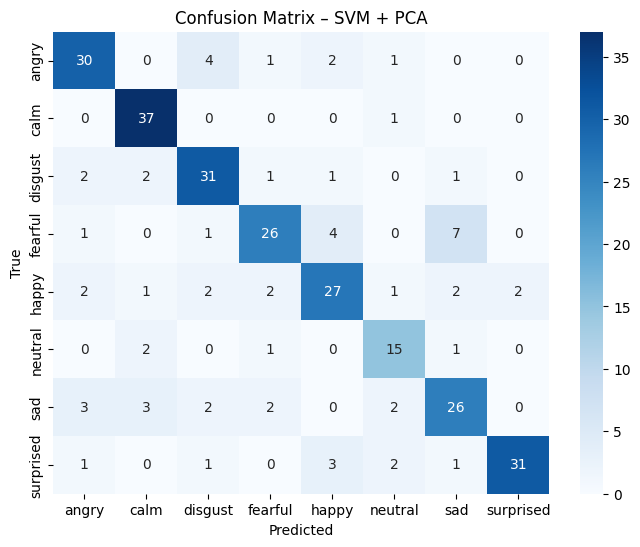


Modell gespeichert unter: svm_pca_model.joblib


In [9]:
# Pipeline
svm_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.99, svd_solver='full', random_state=42)),
    ('clf', SVC(
        kernel='rbf',
        probability=True,
        random_state=42,
        shrinking=True,
        gamma=0.0174,
        class_weight='balanced',
        C=18.87
    ))
])

# K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(svm_pca, X, y, cv=cv, scoring='f1_macro', n_jobs=-1)

print('Support Vector Machine + PCA – Ergebnisse')
print('='*60)
print(f"Cross-Validation (5-fold) Macro-F1: {scores.mean():.2f} ± {scores.std():.2f}")
print('-'*60)

# Trainieren
svm_pca.fit(X_train, y_train)

# Evaluieren
y_pred = svm_pca.predict(X_test)

# Report formatieren
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).T
report_df['precision'] = report_df['precision'].map('{:.2f}'.format)
report_df['recall']    = report_df['recall'].map('{:.2f}'.format)
report_df['f1-score']  = report_df['f1-score'].map('{:.2f}'.format)
report_df['support']   = report_df['support'].astype(int)

print('Test-Set Performance:\n')
print(report_df.to_string())
print('-'*60)
print(f"Accuracy : {accuracy_score(y_test, y_pred):.2f}")
print(f"Macro F1 : {f1_score(y_test, y_pred, average='macro'):.2f}\n")

# Konfusionsmatrix als Heatmap
labels = sorted(y_test.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix – SVM + PCA')
plt.show()

# Speichern
joblib.dump(svm_pca, 'svm_pca_model.joblib')
print(f"\nModell gespeichert unter: svm_pca_model.joblib")

# Weitere Evaluation der Modelle

In [10]:
# ROC-AUC
def auc_macro(pipe, X, y, enc=None):
    S = pipe.predict_proba(X) if hasattr(pipe, 'predict_proba') else pipe.decision_function(X)
    cls_model = pipe.named_steps['clf'].classes_
    cls_true  = np.unique(y)
    y_use     = enc.transform(y) if enc else y
    cls_use   = enc.transform(cls_true) if enc else cls_true
    order     = [np.where(cls_model == c)[0][0] for c in cls_use]
    S         = S[:, order]
    y_bin     = label_binarize(y_use, classes=cls_use)
    return roc_auc_score(y_bin, S, average='macro', multi_class='ovr')

roc_rows = [
    ('LogReg',        auc_macro(logreg,   X_test, y_test)),
    ('SVM (RBF)',     auc_macro(svm,  X_test, y_test)),
    ('Random Forest', auc_macro(rf,       X_test, y_test)),
    ('XGBoost',       auc_macro(xgb,      X_test, y_test, enc=label_encoder)),
    ('SVM + PCA',     auc_macro(svm_pca,  X_test, y_test)),
]

roc_df = pd.DataFrame(roc_rows, columns=['Modell', 'ROC-AUC (macro, OvR)'])\
         .sort_values('ROC-AUC (macro, OvR)', ascending=False)
roc_df['ROC-AUC (macro, OvR)'] = roc_df['ROC-AUC (macro, OvR)'].round(2)
print(roc_df.to_string(index=False))


       Modell  ROC-AUC (macro, OvR)
    SVM + PCA                  0.96
      XGBoost                  0.95
    SVM (RBF)                  0.92
Random Forest                  0.92
       LogReg                  0.90


**Interpretation:** ROC-AUC über alle Modelle hinweg hoch, d.h. sie erkennen grundsätzlich Muster, aber Schwellen sind nicht optimal. Potenzial für Threshold-Tuning pro Klasse?

In [11]:
# Feature Importance: XGBoost
booster = xgb.named_steps['clf'].get_booster()
gain = booster.get_score(importance_type='gain')
xgb_imp = pd.DataFrame(list(gain.items()), columns=['feature','gain']).sort_values('gain', ascending=False)

print(xgb_imp.head(20).to_string(index=False))

               feature     gain
    mel_spectogram_std 2.937755
               rms_std 2.417953
           mfcc_1_mean 1.916648
   mel_spectogram_mean 1.746958
              rms_mean 1.659533
            mfcc_2_std 1.125526
          mfcc_26_mean 0.984473
  spectral_rolloff_std 0.979793
           mfcc_4_mean 0.937478
            mfcc_3_std 0.858580
           mfcc_38_std 0.850408
            mfcc_1_std 0.833173
           mfcc_20_std 0.831842
           mfcc_6_mean 0.825902
spectral_bandwidth_std 0.822452
            mfcc_7_std 0.813040
           mfcc_40_std 0.808638
           mfcc_32_std 0.792931
           mfcc_29_std 0.757467
           mfcc_5_mean 0.746174


**Interpretation**: XGBoost trennt Emotionen vor allem über Lautstärkevariabilität und spektrale Struktur. MFCCs liefern Zusatzinformationen, aber dominieren nicht allein.

In [12]:
# Feature Importance: SVM + PCA
r = permutation_importance(
    svm, X_test, y_test,
    n_repeats=10, random_state=42, n_jobs=-1,
    scoring='f1_macro'
)

svm_imp = pd.DataFrame({
    'feature': X_test.columns,
    'importance': r.importances_mean,
    'std': r.importances_std
}).sort_values('importance', ascending=False)

print('\nSVM (RBF) Permutation Importance – Top 20')
print(svm_imp.head(20).to_string(index=False))



SVM (RBF) Permutation Importance – Top 20
                feature  importance      std
            mfcc_9_mean    0.029557 0.012544
             mfcc_1_std    0.026591 0.007094
             mfcc_6_std    0.026538 0.009322
             mfcc_9_std    0.026508 0.014655
             mfcc_3_std    0.025180 0.008400
             mfcc_2_std    0.020488 0.013878
 zero_crossing_rate_std    0.019513 0.007818
            mfcc_36_std    0.019411 0.010620
            mfcc_20_std    0.018772 0.009835
zero_crossing_rate_mean    0.018755 0.006135
             mfcc_5_std    0.018075 0.007590
             mfcc_8_std    0.018054 0.007787
           mfcc_18_mean    0.017525 0.006987
 spectral_bandwidth_std    0.017260 0.007182
            mfcc_11_std    0.017229 0.006661
           mfcc_31_mean    0.017121 0.005344
             mfcc_4_std    0.016943 0.008316
            mfcc_7_mean    0.016502 0.012723
            mfcc_16_std    0.016045 0.007807
   spectral_rolloff_std    0.015655 0.009196


**Interpretation:** SVM nutzt zur Trennung der Emotionen vor allem die Frequenzspektren und deren Variabilität.

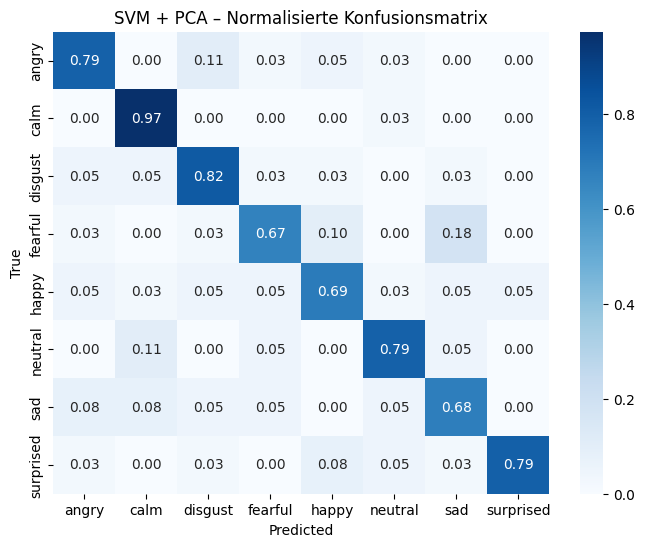

In [13]:
# Normalisierte Konfusionsmatrix für SVM + PCA
cm = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('SVM + PCA – Normalisierte Konfusionsmatrix')
plt.show()

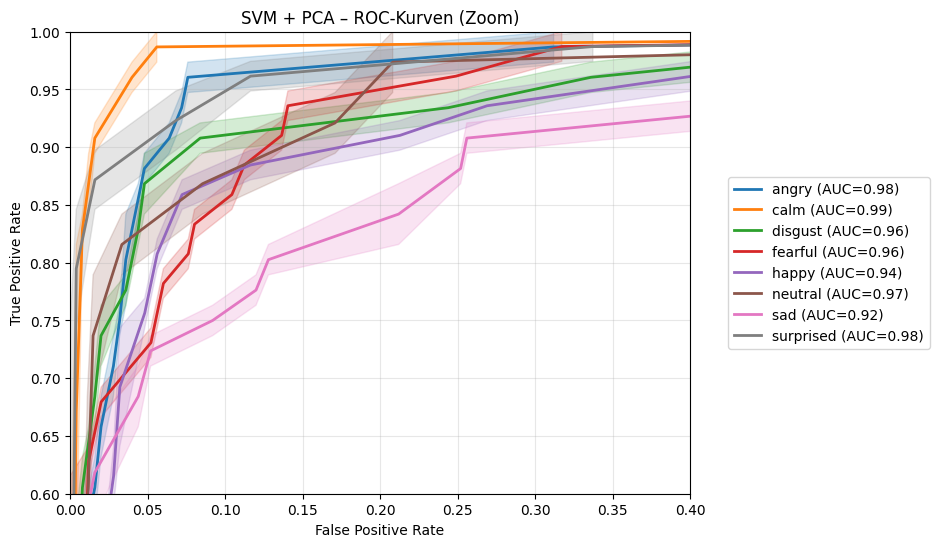

In [14]:
# ROC-Kurven für SVM + PCA

# Labels binarisieren
y_test_bin = label_binarize(y_test, classes=labels)
y_score = svm_pca.predict_proba(X_test)

# Daten sammeln
roc_data = []
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    for f, t in zip(fpr, tpr):
        roc_data.append({'FPR': f, 'TPR': t, 'Klasse': f'{label} (AUC={roc_auc:.2f})'})

roc_df = pd.DataFrame(roc_data)

# Überblicksplot mit Zoom
plt.figure(figsize=(8,6))
sns.lineplot(data=roc_df, x='FPR', y='TPR', hue='Klasse', linewidth=2)
plt.plot([0,1], [0,1], '--', color='grey', lw=1)
plt.xlim([0.0, 0.4])   # Zoom auf relevanten Bereich
plt.ylim([0.6, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM + PCA – ROC-Kurven (Zoom)')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.grid(alpha=0.3)
plt.show()


**Interpretation:** Modell ist insgesamt sehr verlässlich.

*   Leicht zu trennen: *calm*, *angry*, *surprised*
*   Schwerer zu trennen: *sad*, *happy*



# Bewertung und Modell-Auswahl

**SMV + PCA ist das mit Abstand beste Modell.**

---



**Cross-Validation** (Macro-F1 0.79 ± 0.02):
*   Sehr stabil, nur kleine Std.-Abweichung
*   Modell performt über verschiedene Splits hinweg konsistent

**Test-Set** (Accuracy 0.77, Macro-F1 0.77):

*   Passt hervorragend zur Cross-Validation, daher vermutlich kaum Overfitting
*   Macro-F1 zeigt, dass alle Klassen im Schnitt gut erfasst werden

**Klassenweise Analyse:**

*   *calm* und *surprised* : sehr hohe Werte (F1 0.86–0.89)
*   *fearful* und *happy* : schwächere Klassen (F1 0.71–0.72)
*   *neutral* in anderen Modellen problematisch (hier immerhin F1 0.73)

**Offene Fragen**

*   Data Leakage: Gleiche/r Sprecher/in kann in Train & Test sein.
*   Kleiner Datensatz: Gefahr von Overfitting, hohe Varianz zwischen Splits

**Ausblick**

*   Gruppenbasierter Split nach Sprechern
*   Cross-Dataset Evaluation (z.B. mit CREMA-D/TESS)
*   Data Augmentation